# Handwritten Digit Classfication using LSTM

The tutorial presented will again tackle the MNIST digit classification problem. You can find more information from the previous [MNIST introduction](introduction_to_mnist.ipynb) tutorial. This time, we will build a Long short-term memory model to help us classify the digits. Take a look at [this wonderful blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) to gain insights of LSTM.

In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        import matplotlib
matplotlib.use('Agg')
%pylab inline

import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
import matplotlib.pyplot as plt
from utils import get_mnist
from pyspark import SparkContext
from matplotlib.pyplot import imshow
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))

init_engine()

Populating the interactive namespace from numpy and matplotlib


## 1. Load MNIST dataset

First, we should get and store MNIST into RDD of Sample.

Note: *edit the "mnist_path" accordingly. If the "mnist_path" directory does not consist of the mnist data, mnist.read_data_sets method will download the dataset directly to the directory*.

In [2]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

train_data = train_data.map(lambda s: Sample.from_ndarray(np.resize(s.features[0].to_ndarray(), (28, 28)), s.label.to_ndarray()))
test_data = test_data.map(lambda s: Sample.from_ndarray(np.resize(s.features[0].to_ndarray(), (28, 28)), s.label.to_ndarray()))
print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


## 2. Hyperparamter setup

In [3]:
# Parameters
batch_size = 64

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

## 3. Model creation

Let's define our LSTM model here. Rather than adding a RNNcell in the RNN tutorial, now we add LSTM cell into our Recurrent container.

In [4]:
def build_model(input_size, hidden_size, output_size):
    model = Sequential()
    recurrent = Recurrent()
    recurrent.add(LSTM(input_size, hidden_size))
    model.add(InferReshape([-1, input_size], True))
    model.add(recurrent)
    model.add(Select(2, -1))
    model.add(Linear(hidden_size, output_size))
    return model
rnn_model = build_model(n_input, n_hidden, n_classes)

creating: createSequential
creating: createRecurrent
creating: createLSTM
creating: createInferReshape
creating: createSelect
creating: createLinear


## 4. Optimizer setup and training

Let's create an optimizer for training. As presented in the code, we are trying to optimize a [CrossEntropyCriterion](https://bigdl-project.github.io/master/#APIGuide/Losses/#crossentropycriterion) and use [Adam](https://bigdl-project.github.io/master/#APIGuide/Optimizers/Optim-Methods/#adam) to update the weights. Also in order to enable visualization support, we need to [generate summary info in BigDL](https://bigdl-project.github.io/master/#ProgrammingGuide/visualization/).

In [5]:
# Create an Optimizer

#criterion = TimeDistributedCriterion(CrossEntropyCriterion())
criterion = CrossEntropyCriterion()
optimizer = Optimizer(
    model=rnn_model,
    training_rdd=train_data,
    criterion=criterion,
    optim_method=Adam(),
    end_trigger=MaxEpoch(5),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='rnn-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to ",app_name

creating: createCrossEntropyCriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  rnn-20171107-134705


In [6]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 29.3 ms, sys: 12.6 ms, total: 41.8 ms
Wall time: 6min 7s


## 5. Prediction on test data

In [7]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

Ground Truth labels:
7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9
CPU times: user 52.8 ms, sys: 4.8 ms, total: 57.6 ms
Wall time: 1.99 s


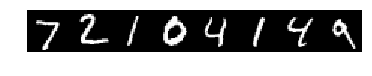

In [8]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print 'Ground Truth labels:'
print ', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8))
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s)) for s in predictions.take(8))